In [8]:
import numpy as np
import math
from math import pi
from matplotlib import pyplot as plt

import qiskit
from qiskit import QuantumCircuit, transpile,  assemble
from qiskit_aer import AerSimulator,Aer

from qiskit.visualization import *

from qiskit import ClassicalRegister, QuantumRegister, transpile
#from qiskit.tools.visualization import circuit_drawer
from qiskit.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity, Statevector, SparsePauliOp, Operator
#from qiskit import BasicAer

from qiskit.quantum_info.operators import Operator, Pauli

import qiskit.quantum_info as qi

import itertools
from itertools import combinations

from qiskit import *

# Need gate classes for generating the Pauli twirling sets
from qiskit.circuit.library import (IGate, XGate, YGate, ZGate,
                                    CXGate, CZGate, ECRGate, iSwapGate,QFT, RYGate, RZGate)

# Classes for building up a directed-acyclic graph (DAG) structure
from qiskit.circuit import QuantumRegister,Parameter, ParameterVector, CircuitInstruction
from qiskit.dagcircuit import DAGCircuit

# Transpiler stuff needed to make a pass and passmanager
from qiskit.transpiler import PassManager
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler.passes import Optimize1qGatesDecomposition,CommutativeCancellation,CXCancellation,Optimize1qGatesSimpleCommutation

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [10]:
print(qiskit.version.get_version_info())

1.2.0


In [11]:
%run SetUp.ipynb

In [12]:
nQ

20

In [13]:
# 20 qubit angles based on Anthony's plot
angles_from_vqe = [0.1781, 0.10]

In [14]:
nQ = 20 # nq needs to be even
m = 1.
g = 2.

In [25]:
import h5py

with h5py.File('/Users/zhiyaoli/IQuS Dropbox/Zhiyao Li/String Breaking/Data/eigenstates20.h5', 'r') as f:
    data = f['Dataset1'][:]
    
    
real_part = data[-1]["Re"]
imag_part = data[-1]["Im"]
numerical_vacuum = real_part + 1j * imag_part

# Circuit Construction

## Initialize Vacuum


In [15]:
# prototype. activate nl links in the middle of the circuit

def activate(nl, nq = nQ, cir = None):
    if nq <= nl: raise Exception (" Size of system needs to be bigger than the number of links being activated. ")
    if cir == None: cir = QuantumCircuit(nq)
    loc = (nq-nl) // 2
    for i in range(nl):
        cir.x(loc+i)
    return cir

In [16]:
# apply the VQE that initialize the circuit into true vacuum to circuit

def true_vac(angles = angles_from_vqe, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    
    # even index operations
    for i in range(nq//2): # odd sites go to y basis
        cir.sdg(2*i+1)
        cir.h(2*i+1)    
    for i in range(nq//2):
        cir.rz((angles[0]+angles[1])/2, 2*i+1) # applying the single y gate
        cir.cx(2*i+1, (2*i+2)%nq)                      # applying IYZ
        cir.rz((angles[0]- angles[1])/2, (2*i+2)%nq)
        cir.cx(2*i+1, (2*i+2)%nq)
    for i in range(nq//2):   # applying ZYI, CNOT on the right cancelled with CNOT in ZYZ
        cir.cx(2*i, 2*i+1)                      
        cir.rz((angles[0] - angles[1])/2, 2*i+1)
    for i in range(nq//2):  # applying ZYZ, CNOT on the left cancelled
        cir.cx(2*i+1, (2*i+2)%nq)
        cir.rz((angles[0] + angles[1])/2, (2*i+2)%nq)
        cir.cx(2*i+1, (2*i+2)%nq)
        cir.cx(2*i, 2*i+1)  
    for i in range(nq//2): # odd sites go to y basis
        cir.h(2*i+1)   
        cir.s(2*i+1)
    
    #cir.barrier() # for visualization purposes
     
    # odd index operations
    for i in range(nq//2): # even sites go to y basis
        cir.sdg(2*i)
        cir.h(2*i)  
    for i in range(nq//2):
        cir.rz((angles[0]+angles[1])/2, 2*i) # applying the single y gate
        cir.cx(2*i, (2*i+1)%nq)                      # applying IYZ
        cir.rz((angles[0]- angles[1])/2, (2*i+1)%nq)
        cir.cx(2*i, (2*i+1)%nq)  
    for i in range(nq//2):   # applying ZYI, CNOT on the right cancelled with CNOT in ZYZ
        cir.cx(2*i+1, (2*i+2)%nq)                      
        cir.rz((angles[0] - angles[1])/2, (2*i+2)%nq)
    for i in range(nq//2):  # applying ZYZ, CNOT on the left cancelled
        cir.cx((2*i+2)%nq, (2*i+3)%nq)
        cir.rz((angles[0] + angles[1])/2, (2*i+3)%nq)
        cir.cx((2*i+2)%nq, (2*i+3)%nq)
        cir.cx(2*i+1, (2*i+2)%nq)
    for i in range(nq//2): # even sites go to y basis
        cir.h(2*i)
        cir.s(2*i)
        
    return cir

In [17]:
# by applying $U^\dagger(\Vec{\theta})$ before performing measurements
# qubits in the $\ket{1}$ state can be interpreted as having a meson present at that site
# while qubits in the $\ket{0}$ state correspond to the vacuum

def inv_vac(nq = nQ,cir=None):
    if cir == None: cir = QuantumCircuit(nq)
    true_vac_cir = true_vac(angles = angles_from_vqe, nq = nq)
    inv_true_vac = true_vac_cir.inverse()
    cir.compose(inv_true_vac,inplace = True)
    return cir

## Construct Hamiltonian for QC

In [18]:
from math import sqrt


def exp_hkin_even(t, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    angles = (1/math.sqrt(2),1/(2* math.sqrt(2)))
    for i in range(nq//2): # odd sites go to x basis
        cir.h(2*i+1)    
    for i in range(nq//2):
        cir.rz((angles[0]+angles[1])*t/2, 2*i+1) # applying the single x gate
        cir.cx(2*i+1, (2*i+2)%nq)                      # applying IXZ
        cir.rz((angles[0]- angles[1])*t/2, (2*i+2)%nq)
        cir.cx(2*i+1, (2*i+2)%nq)
    for i in range(nq//2):   # applying ZXI, CNOT on the right cancelled with CNOT in ZXZ
        cir.cx(2*i, 2*i+1)                      
        cir.rz((angles[0] - angles[1])*t/2, 2*i+1)
    for i in range(nq//2):  # applying ZXZ, CNOT on the left cancelled
        cir.cx(2*i+1, (2*i+2)%nq)
        cir.rz((angles[0] + angles[1])*t/2, (2*i+2)%nq)
        cir.cx(2*i+1, (2*i+2)%nq)
        cir.cx(2*i, 2*i+1)  
    for i in range(nq//2): # odd sites go to x basis
        cir.h(2*i+1)   
    return cir

def exp_hkin_odd(t, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    angles = (1/math.sqrt(2),1/(2* math.sqrt(2)))
    for i in range(nq//2): # even sites go to x basis
        cir.h(2*i)  
    for i in range(nq//2):
        cir.rz((angles[0]+angles[1])*t/2, 2*i) # applying the single x gate
        cir.cx(2*i, (2*i+1)%nq)                      # applying IXZ
        cir.rz((angles[0]- angles[1])*t/2, (2*i+1)%nq)
        cir.cx(2*i, (2*i+1)%nq)  
    for i in range(nq//2):   # applying ZXI, CNOT on the right cancelled with CNOT in ZXZ
        cir.cx(2*i+1, (2*i+2)%nq)                      
        cir.rz((angles[0] - angles[1])*t/2, (2*i+2)%nq)
    for i in range(nq//2):  # applying ZXZ, CNOT on the left cancelled
        cir.cx((2*i+2)%nq, (2*i+3)%nq)
        cir.rz((angles[0] + angles[1])*t/2, (2*i+3)%nq)
        cir.cx((2*i+2)%nq, (2*i+3)%nq)
        cir.cx(2*i+1, (2*i+2)%nq)
    for i in range(nq//2): # even sites go to x basis
        cir.h(2*i)
    return cir

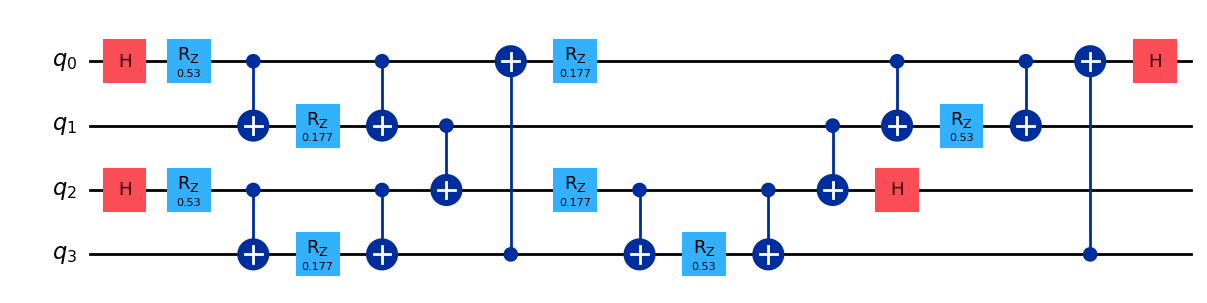

In [37]:
exp_hkin_odd(1,4).draw('mpl')

In [34]:
def exp_hm(t, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    for i in range(nq//2):
        cir.cx(2*i, (2*i+1)%nq)
        cir.rz(-m*t, (2*i+1)%nq)
        cir.cx(2*i, (2*i+1)%nq)
    for i in range(nq//2):
        cir.cx(2*i+1, (2*i+2)%nq)
        cir.rz(-m*t, (2*i+2)%nq)
        cir.cx(2*i+1, (2*i+2)%nq)
    return cir

In [20]:
def exp_he(t, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    for i in range(nq):
        cir.rz(-3*t*g**2/8,i)
    return cir

## Time Evolution

In [21]:
def trotter_step(dt, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    exp_hkin_odd(dt/2, nq, cir) # can save cost by preconstructing kin_odd and kin_even and do cir.compose(kin_odd)
    exp_hkin_even(dt/2, nq, cir) # leaving as is for now until it is required to save compilation time
    exp_hm(dt, nq, cir)
    exp_he(dt, nq, cir)
    exp_hkin_even(dt/2, nq, cir)
    exp_hkin_odd(dt/2, nq, cir)
    return cir

In [22]:
def time_ev(dt,steps, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    for i in range(steps):
        trotter_step(dt, nq, cir)
    return cir

# Run

## Examine Vacuum time evolution to find a small enough dt

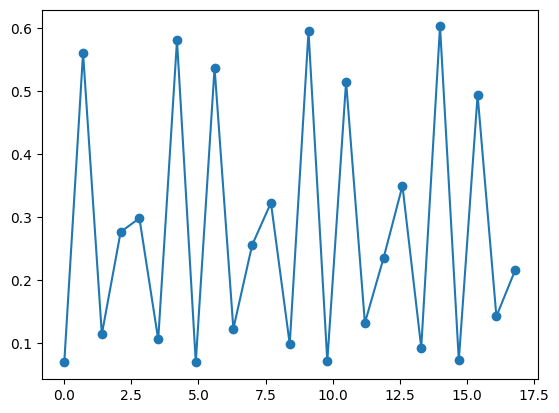

In [26]:
del_t = 0.7
overlaps = []

for i in range(25):
    vac_cir = true_vac(angles_from_vqe)
    result_state = Statevector.from_int(0, 2**nQ)
    result_state = result_state.evolve(time_ev(del_t, i, nQ, vac_cir))
    overlaps.append(qiskit.quantum_info.state_fidelity(result_state,numerical_vacuum))
    
plt.plot(np.arange(0, 16.8, 0.7),overlaps, 'o-')

# Classical Simulation and Measurements of Observables

#### Electric energy per site

In [16]:
# Expectation value of electric hamiltonian per site

from operator import inv


del_t = 0.7
steps = np.arange(0,25, 1) 
sites = np.arange(0, nQ, 1) 

# initialize the list to save observable results
e_per_site_time = []

for i in steps:
    # Initialize the circuit with 3 links activated 
    circir = QuantumCircuit(nQ)
    activate(3,nQ,circir)
    true_vac(angles_from_vqe,nQ,circir)
    time_ev(del_t, i, nQ, circir)
    inv_vac(nQ,circir)
    
    result_state = Statevector.from_int(0, 2**nQ)
    result_state = result_state.evolve(circir)
    
    result_probs = padbitstringDict(result_state.probabilities_dict())
    
    E_exps = []
    for j in sites:
        E_exps.append(np.dot(np.real(He_persite(j).to_matrix(sparse = True).diagonal()),result_probs)) # can do this because electric hamiltonian is diagonal
    e_per_site_time.append(E_exps)


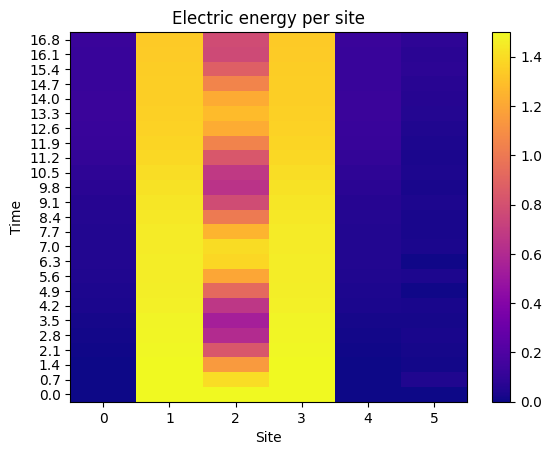

In [17]:
plt.pcolormesh(sites, steps, e_per_site_time)
plt.colorbar()
plt.set_cmap('plasma')
# plt.clim(0.9729,0.99)
plt.xticks(sites)
plt.yticks(ticks = steps, labels = [ 0. ,  0.7,  1.4,  2.1,  2.8,  3.5,  4.2,  4.9,  5.6,  6.3,  7. ,
        7.7,  8.4,  9.1,  9.8, 10.5, 11.2, 11.9, 12.6, 13.3, 14. , 14.7,
       15.4, 16.1, 16.8])
plt.xlabel("Site")
plt.ylabel("Time")
plt.title("Electric energy per site")
plt.show()

#### Entanglement Entropy

#### Chiral Condensate

In [18]:
# Expectation value of mass hamiltonian per site

del_t = 0.7
steps = np.arange(0,25, 1) 
sites = np.arange(0, nQ, 1) 

# initialize the list to save observable results
m_per_site_time = []

for i in steps:
    # Initialize the circuit with 3 links activated 
    circir = QuantumCircuit(nQ)
    activate(3,nQ,circir)
    true_vac(angles_from_vqe,nQ,circir)
    time_ev(del_t, i, nQ, circir)
    inv_vac(nQ,circir)
    
    result_state = Statevector.from_int(0, 2**nQ)
    result_state = result_state.evolve(circir)
    
    result_probs = padbitstringDict(result_state.probabilities_dict())
    
    M_exps = []
    for j in sites:
        M_exps.append(np.dot(np.real(Hm_persite(j).to_matrix(sparse = True).diagonal()),result_probs)) # can do this because electric hamiltonian is diagonal
    m_per_site_time.append(M_exps)

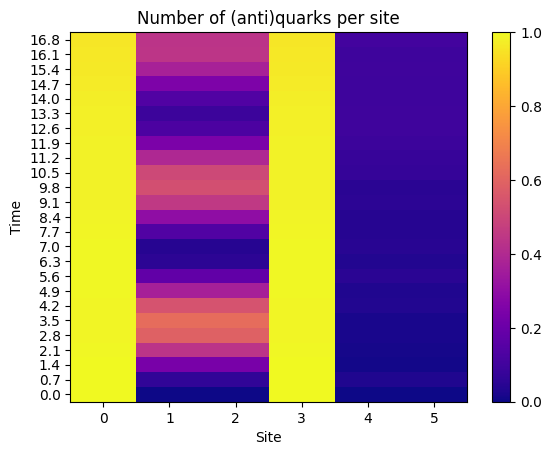

In [19]:
plt.pcolormesh(sites, steps, m_per_site_time)
plt.colorbar()
plt.set_cmap('plasma')
# plt.clim(0.9729,0.99)
plt.xticks(sites)
plt.yticks(ticks = steps, labels = [ 0. ,  0.7,  1.4,  2.1,  2.8,  3.5,  4.2,  4.9,  5.6,  6.3,  7. ,
        7.7,  8.4,  9.1,  9.8, 10.5, 11.2, 11.9, 12.6, 13.3, 14. , 14.7,
       15.4, 16.1, 16.8])
plt.xlabel("Site")
plt.ylabel("Time")
plt.title("Number of (anti)quarks per site")
plt.show()

#### P0xP1(x+1) + P1xP0(x+1) sum over sites over time

# Quantum Simulation

## Noiseless check

In [37]:
simulator = Aer.get_backend('qasm_simulator')

In [88]:
del_t = 0.7
steps = np.arange(0,8, 1) 
sites = np.arange(0, nQ, 1) 
cirlist = []

for i in steps:
    circir = QuantumCircuit(nQ)
    activate(3,nQ,circir)     # Initialize the circuit with 3 links activated 
    true_vac(angles_from_vqe,nQ,circir)
    time_ev(del_t, i, nQ, circir)
    inv_vac(nQ,circir)
    circir.measure_all()
    
    circir_tran = qiskit.compiler.transpile(circir,
                                                    backend=simulator, #probably won't work for number of qubits > 32
                                                    optimization_level=3 )
    
    print(f'  depth: {circir_tran.depth()}')
    print(f'  CNOT depth:{circir_tran.depth(filter_function=lambda x: len(x.qubits)>1)}')
    print(f'  gate counts: {circir_tran.count_ops()}')
    print("--------------")
    
    cirlist.append(circir_tran)

  depth: 29
  CNOT depth:18
  gate counts: OrderedDict([('cx', 30), ('rz', 16), ('u2', 8), ('measure', 6), ('unitary', 2), ('x', 1), ('barrier', 1)])
--------------
  depth: 96
  CNOT depth:61
  gate counts: OrderedDict([('cx', 98), ('rz', 54), ('u2', 12), ('h', 8), ('unitary', 7), ('measure', 6), ('x', 1), ('barrier', 1)])
--------------
  depth: 163
  CNOT depth:104
  gate counts: OrderedDict([('cx', 166), ('rz', 95), ('u2', 16), ('h', 13), ('unitary', 12), ('measure', 6), ('x', 1), ('barrier', 1)])
--------------
  depth: 230
  CNOT depth:147
  gate counts: OrderedDict([('cx', 234), ('rz', 136), ('u2', 20), ('h', 18), ('unitary', 17), ('measure', 6), ('x', 1), ('barrier', 1)])
--------------
  depth: 297
  CNOT depth:190
  gate counts: OrderedDict([('cx', 302), ('rz', 177), ('u2', 24), ('h', 23), ('unitary', 22), ('measure', 6), ('x', 1), ('barrier', 1)])
--------------
  depth: 364
  CNOT depth:233
  gate counts: OrderedDict([('cx', 370), ('rz', 218), ('u2', 28), ('h', 28), ('unita

In [90]:
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)

In [92]:
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

In [107]:
# transpile circuit to specific backend


circir_transpiled = qiskit.compiler.transpile(cirlist,
                                                    backend=backend,
                                                    optimization_level=1
                                                   )

# or

isa_circir = pm.run(cirlist)

In [110]:
isa_circir

In [91]:
backend

<IBMBackend('ibm_kyoto')>

In [95]:
sampler = Sampler(simulator)
 
sampler.options.twirling.enable_gates = True
sampler.options.twirling.enable_measure = True
sampler.options.twirling.num_randomizations = 40
sampler.options.twirling.shots_per_randomization = 1000

sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = 'XY4'
 
print(f">>> dynamical decoupling is turned on: {sampler.options.dynamical_decoupling.enable}")
print(f">>> gate twirling is turned on: {sampler.options.twirling.enable_gates}")
 

>>> dynamical decoupling is turned on: True
>>> gate twirling is turned on: True


In [96]:
sampler_job = sampler.run(cirlist)
print(f">>> Job ID: {sampler_job.job_id()}")
print(f">>> Job Status: {sampler_job.status()}")

>>> Job ID: 30c35968-dd6f-430a-9a85-085dc859ca92
>>> Job Status: JobStatus.RUNNING


/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'enable_measure': True, 'num_randomizations': 40, 'shots_per_randomization': 1000}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [115]:
with Session(backend = simulator) as session:
    sampler = Sampler(simulator)
    sampler_job = sampler.run(cirlist)
    print(f">>> Job ID: {sampler_job.job_id()}")
    print(f">>> Job Status: {sampler_job.status()}")

>>> Job ID: c0afc7ab-52e2-44a8-ac58-295fc1287744
>>> Job Status: JobStatus.RUNNING


In [116]:
sampler_result = sampler_job.result()

In [105]:
sampler_result._pub_results[0].data.meas.get_counts()

{'001110': 986, '101110': 35, '001010': 3}

In [117]:
for idx, pub_result in enumerate(sampler_result):
    print(f" > Counts for pub {idx}: {pub_result.data.meas.get_counts()}")

 > Counts for pub 0: {'001110': 995, '101110': 24, '001010': 5}
 > Counts for pub 1: {'111110': 1, '001110': 960, '001010': 58, '101110': 4, '101111': 1}
 > Counts for pub 2: {'001110': 777, '001010': 220, '101110': 17, '000010': 1, '101111': 4, '111111': 1, '010010': 1, '101011': 1, '111010': 1, '101010': 1}
 > Counts for pub 3: {'001010': 434, '001110': 573, '000010': 2, '010010': 2, '111110': 1, '111011': 2, '001000': 3, '101110': 2, '101010': 3, '101011': 1, '111010': 1}
 > Counts for pub 4: {'001010': 538, '001110': 455, '111111': 2, '001001': 6, '101110': 4, '101010': 3, '001000': 2, '010010': 6, '111011': 2, '110110': 1, '101111': 1, '000010': 2, '101011': 1, '111010': 1}
 > Counts for pub 5: {'001110': 435, '001010': 555, '001000': 6, '001001': 10, '010010': 7, '000010': 1, '101010': 1, '100011': 1, '111011': 3, '101110': 4, '101011': 1}
 > Counts for pub 6: {'001110': 480, '001010': 502, '001001': 14, '101010': 5, '101110': 4, '111110': 2, '010010': 11, '011101': 1, '101011': 

In [120]:
# turn a list of counts into quasi_dists

def quasi_dists(sampler_result):
    results = []
    for i, pub_result in enumerate(sampler_result):
        counts = pub_result.data.meas.get_counts()
        coeffs = [0] * np.power(2, nQ)
        count_list = [val for _,val in counts.items()]
        for i in range(2**nQ):
            coeffs[i] = sum([val for key,val in counts.items() if index_from_bitstring(key) == i]) / sum(count_list)
        results.append(coeffs)
        
        # Compute the expectation value: tr(rho*E)
        # rho = np.diag(coeffs)
        # result = np.trace(np.dot(rho, E))
        # results.append(result)
        
    return results